# GeoParquet Konverteringsverktøy

Dette verktøyet konverterer geografiske datafiler til GeoParquet-format.

## Hvordan bruke dette verktøyet

1. Last opp dine geografiske datafiler til mappen `data/råfiler`
2. Kjør alle cellene i denne notebooken
3. De konverterte filene vil bli lagret i mappen `data/prosessert`

## Støttede filformater

- CSV-filer med latitude/longitude kolonner
- Parquet-filer med geografisk informasjon
- GeoJSON-filer (.geojson, .json)
- Shapefiler (.shp)
- GeoPackage-filer (.gpkg)


## Last inn nødvendige pakker

Kjør cellen nedenfor for å importere pakkene som verktøyet trenger:

In [4]:
# pip install -r requirements.txt

In [24]:
# Importerer nødvendige pakker
import os                             # Operativsystem-funksjoner og filhåndtering
import pandas as pd                   # Databehandling og analyse
import geopandas as gpd               # Geografisk databehandling 
import fiona                          # Håndtering av geografiske filformater 
import matplotlib.pyplot as plt       # Plotting og visualisering
from IPython.display import display   # Forbedret visning i notebook
import contextily as ctx              # Bakgrunnskart og kontekst til kart
import numpy as np                    # Numeriske operasjoner

## 2. Definer konverteringsfunksjoner
Kjør cellen nedenfor for å definere funksjonene som konverterer filene:

In [7]:
def konverter_parquet_til_geoparquet(filsti, målfilsti):
    """Konverterer parquet-fil til GeoParquet-format"""
    df = pd.read_parquet(filsti)
    
    # Sjekk etter lat/long kolonner
    if 'longitude' in df.columns and 'latitude' in df.columns:
        gdf = gpd.GeoDataFrame(
            df, 
            geometry=gpd.points_from_xy(df.longitude, df.latitude),
            crs="EPSG:4326"
        )
        gdf.to_parquet(målfilsti)
        return målfilsti
    
    # Sjekk etter potensielle geometrikolonner
    geom_kolonner = [col for col in df.columns if any(term in col.lower() for term in 
                   ['geom', 'coord', 'point', 'polygon', 'linestring', 'wkt'])]
    
    for col in geom_kolonner:
        # Prøv å konvertere fra WKT-format hvis det er en tekstkolonne
        if df[col].dtype == 'object':
            try:
                geom = df[col].apply(wkt.loads)
                gdf = gpd.GeoDataFrame(df, geometry=geom, crs="EPSG:4326")
                gdf.to_parquet(målfilsti)
                return målfilsti
            except Exception:
                continue  # Prøv neste kolonne hvis denne ikke fungerer
    
    return False  # Ingen geometri funnet

def konverter_geojson_til_geoparquet(filsti, målfilsti):
    """Konverterer GeoJSON-fil til GeoParquet-format"""
    gdf = gpd.read_file(filsti)
    gdf.to_parquet(målfilsti)
    return målfilsti

def konverter_shapefile_til_geoparquet(filsti, målfilsti):
    """Konverterer Shapefile til GeoParquet-format med validering"""
    try:
        # Sett miljøvariabel for å håndtere manglende .shx filer
        import os
        os.environ['SHAPE_RESTORE_SHX'] = 'YES'
        
        # Les shapefile
        gdf = gpd.read_file(filsti)
        
        # Sjekk om det faktisk er geometri i filen
        if 'geometry' not in gdf.columns or len(gdf) == 0:
            print(f"Advarsel: Ingen geometrier funnet i {filsti}")
            return False
            
        # Sjekk og reparer ugyldige geometrier
        invalid_count = sum(~gdf.geometry.is_valid)
        if invalid_count > 0:
            print(f"Reparerer {invalid_count} ugyldige geometrier i {filsti}")
            gdf['geometry'] = gdf.geometry.buffer(0)  # Fikser geometrier
        
        # Fjern alle NaN geometrier
        orig_len = len(gdf)
        gdf = gdf.dropna(subset=['geometry'])
        if len(gdf) < orig_len:
            print(f"Fjernet {orig_len - len(gdf)} rader med manglende geometri")
        
        # Sjekk at vi fortsatt har geometrier
        if len(gdf) == 0:
            print(f"Advarsel: Ingen gyldige geometrier igjen etter validering i {filsti}")
            return False
            
        # Sjekk at CRS er definert
        if gdf.crs is None:
            print(f"Advarsel: Manglende CRS i {filsti}, antar WGS84")
            gdf.set_crs(epsg=4326, inplace=True)
        
        # Lagre til parquet
        gdf.to_parquet(målfilsti)
        return målfilsti
    except Exception as e:
        print(f"Feil ved konvertering av shapefile {filsti}: {e}")
        return False

def konverter_geopackage_til_geoparquet(filsti, målfilsti):
    """Konverterer GeoPackage til GeoParquet-format"""
    gdf = gpd.read_file(filsti, driver='GPKG')
    gdf.to_parquet(målfilsti)
    return målfilsti
    
def konverter_gml_til_geoparquet(filsti, målfilsti, lag=None):
    """
    Konverterer GML-fil til GeoParquet-format
    
    Args:
        filsti: Sti til GML-filen
        målfilsti: Sti hvor GeoParquet-filen skal lagres
        lag: Spesifikt lag som skal konverteres (hvis None, brukes første lag)
    """
    try:
        if lag is None:
            # Les alle lag for å identifisere tilgjengelige lag
            tilgjengelige_lag = fiona.listlayers(filsti)
            
            if not tilgjengelige_lag:
                print(f"Ingen lag funnet i GML-filen: {filsti}")
                return False
                
            # Bruk det første laget
            print(f"Bruker første lag '{tilgjengelige_lag[0]}' fra {len(tilgjengelige_lag)} tilgjengelige lag")
            gdf = gpd.read_file(filsti, layer=tilgjengelige_lag[0])
        else:
            # Bruk det spesifiserte laget
            gdf = gpd.read_file(filsti, layer=lag)
        
        gdf.to_parquet(målfilsti)
        return målfilsti
    except Exception as e:
        print(f"Feil ved konvertering av GML-fil {filsti}: {e}")
        return False

def konverter_csv_til_geoparquet(filsti, målfilsti):
    """Konverterer CSV-fil til GeoParquet-format"""
    df = pd.read_csv(filsti)
    
    # Sjekk for vanlige lat/long kolonnenavn
    lat_kolonner = ['latitude', 'lat', 'y', 'breddegrad']
    lon_kolonner = ['longitude', 'long', 'lon', 'x', 'lengdegrad']
    
    lat_col = next((col for col in lat_kolonner if col in df.columns), None)
    lon_col = next((col for col in lon_kolonner if col in df.columns), None)
    
    if lat_col and lon_col:
        gdf = gpd.GeoDataFrame(
            df, 
            geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
            crs="EPSG:4326"
        )
        gdf.to_parquet(målfilsti)
        return målfilsti
    
    return False  # Ingen lat/long kolonner funnet

def konverter_til_geoparquet(kildefilsti, målmappesti, gml_lag=None):
    """Konverterer ulike geografiske formater til GeoParquet-format"""
    try:
        # Få filnavn uten endelse
        base_navn = os.path.basename(kildefilsti)
        base_navn_uten_endelse = os.path.splitext(base_navn)[0]
        filendelse = os.path.splitext(kildefilsti)[1].lower()
        
        # Bestem målfilsti
        målfilsti = os.path.join(målmappesti, f"{base_navn_uten_endelse}.parquet")
        
        # Velg riktig konverteringsfunksjon basert på filtype
        if filendelse == '.parquet':
            return konverter_parquet_til_geoparquet(kildefilsti, målfilsti)
        elif filendelse in ['.geojson', '.json']:
            return konverter_geojson_til_geoparquet(kildefilsti, målfilsti)
        elif filendelse == '.shp':
            return konverter_shapefile_til_geoparquet(kildefilsti, målfilsti)
        elif filendelse == '.gpkg':
            return konverter_geopackage_til_geoparquet(kildefilsti, målfilsti)
        elif filendelse == '.csv':
            return konverter_csv_til_geoparquet(kildefilsti, målfilsti)
        elif filendelse == '.gml':
            return konverter_gml_til_geoparquet(kildefilsti, målfilsti, gml_lag)
        else:
            return False  # Ikke-støttet filformat
            
    except Exception as e:
        print(f"Feil ved konvertering av {kildefilsti}: {e}")
        return False

def konverter_alle_filer(data_mappe, gml_lag=None):
    """Konverterer alle støttede filer fra råfiler til prosessert-mappen"""
    
    # Definer mappestruktur
    rå_mappe = os.path.join(data_mappe, "råfiler")
    prosessert_mappe = os.path.join(data_mappe, "prosessert")
    
    # Opprett mapper hvis de ikke eksisterer
    os.makedirs(rå_mappe, exist_ok=True)
    os.makedirs(prosessert_mappe, exist_ok=True)
    
    # Støttede filformater
    støttede_formater = ['.parquet', '.geojson', '.json', '.shp', '.gpkg', '.csv', '.gml']
    
    # Hold styr på resultater
    resultater = {
        "konvertert": [],
        "feilet": []
    }
    
    # Gå gjennom alle filer i råfiler-mappen
    for filnavn in os.listdir(rå_mappe):
        filsti = os.path.join(rå_mappe, filnavn)
        
        # Hopp over mapper
        if not os.path.isfile(filsti):
            continue
            
        filendelse = os.path.splitext(filnavn)[1].lower()
        
        # Sjekk om filen har et støttet format
        if filendelse in støttede_formater:
            # Konverter filen
            målfilsti = konverter_til_geoparquet(filsti, prosessert_mappe, gml_lag)
            
            if målfilsti:
                resultater["konvertert"].append(filsti)
                print(f"Konvertert: {filsti} -> {målfilsti}")
            else:
                resultater["feilet"].append(filsti)
                print(f"Kunne ikke konvertere: {filsti}")
    
    # Vis oppsummering
    print("\n=== OPPSUMMERING ===")
    print(f"Antall filer konvertert til GeoParquet: {len(resultater['konvertert'])}")
    print(f"Antall filer som ikke kunne konverteres: {len(resultater['feilet'])}")
    
    return resultater

def start_konvertering(data_mappe="./data", gml_lag=None):
    """
    Start konverteringsprosessen i Jupyter Notebook
    
    Args:
        data_mappe: Sti til datamappen som inneholder råfiler og hvor prosessert skal opprettes
        gml_lag: Spesifikt lag som skal konverteres fra GML-filer (hvis None, brukes første lag)
    """
    print(f"Starter konvertering av filer i {data_mappe}")
    return konverter_alle_filer(data_mappe, gml_lag)

def analyser_geoparquet(filsti):
    """Analyserer innholdet i en GeoParquet-fil for å finne problemer"""
    gdf = gpd.read_parquet(filsti)
    print(f"Filinfo: {os.path.basename(filsti)}")
    print(f"Dimensjoner: {gdf.shape}")
    print(f"Kolonner: {gdf.columns.tolist()}")
    print(f"CRS: {gdf.crs}")
    
    if 'geometry' in gdf.columns:
        print("\nGeometrianalyse:")
        print(f"Geometrityper: {gdf.geometry.geom_type.unique()}")
        
        # Sjekk for tomme geometrier
        empty_count = sum(gdf.geometry.is_empty)
        print(f"Tomme geometrier: {empty_count}")
        
        # Sjekk for ugyldige geometrier
        try:
            invalid_count = sum(~gdf.geometry.is_valid)
            print(f"Ugyldige geometrier: {invalid_count}")
        except:
            print("Kunne ikke sjekke geometrivaliditet")
        
        # Sjekk for NaN-verdier
        nan_count = gdf.geometry.isna().sum()
        print(f"NaN geometrier: {nan_count}")
        
        # Sjekk bounding box
        try:
            bounds = gdf.total_bounds
            print(f"Bounding box: {bounds}")
            if np.isnan(bounds).any() or np.isinf(bounds).any():
                print("Advarsel: Bounding box inneholder NaN eller Inf verdier")
        except Exception as e:
            print(f"Kunne ikke beregne bounding box: {e}")
    
    # Vis de første radene
    print("\nFørste rader:")
    display(gdf.head())



## 3. Opprett mappestruktur

Kjør cellen nedenfor for å opprette nødvendige mapper:

In [9]:
# Definerer sti til datamappen
data_mappe = "./data"

# Opprett hovedmappen hvis den ikke eksisterer
os.makedirs(data_mappe, exist_ok=True)

# Oppretter mappestrukturen
rå_mappe = os.path.join(data_mappe, "råfiler")
prosessert_mappe = os.path.join(data_mappe, "prosessert")

# Oppretter mappene hvis de ikke eksisterer
os.makedirs(rå_mappe, exist_ok=True)
os.makedirs(prosessert_mappe, exist_ok=True)

print(f"Mappestruktur opprettet:")
print(f"- Råfiler: {os.path.abspath(rå_mappe)}")
print(f"- Prosessert: {os.path.abspath(prosessert_mappe)}")

# Viser eventuelle filer som allerede ligger i råfiler-mappen
filer_i_råmappe = [f for f in os.listdir(rå_mappe) if os.path.isfile(os.path.join(rå_mappe, f))]
if filer_i_råmappe:
    print("\nFiler som er klare for konvertering:")
    for fil in filer_i_råmappe:
        filsti = os.path.join(rå_mappe, fil)
        filstørrelse = os.path.getsize(filsti) / 1024  # KB
        filendelse = os.path.splitext(fil)[1].lower()
        print(f"- {fil} ({filstørrelse:.1f} KB) - {filendelse} fil")
else:
    print("\nIngen filer funnet i råfiler-mappen.")
    print("Last opp filer til råfiler-mappen før du starter konverteringen.")

# Vis eventuelle filer som allerede finnes i prosessert-mappen
filer_i_prosessert = [f for f in os.listdir(prosessert_mappe) if os.path.isfile(os.path.join(prosessert_mappe, f))]
if filer_i_prosessert:
    print("\nAllerede konverterte filer i prosessert-mappen:")
    for fil in filer_i_prosessert:
        filsti = os.path.join(prosessert_mappe, fil)
        filstørrelse = os.path.getsize(filsti) / 1024  # KB
        print(f"- {fil} ({filstørrelse:.1f} KB)")

Mappestruktur opprettet:
- Råfiler: /Users/christine/00 Bachelortesting/usecase1_parquet_v3/data/råfiler
- Prosessert: /Users/christine/00 Bachelortesting/usecase1_parquet_v3/data/prosessert

Filer som er klare for konvertering:
- Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.gfs (7.0 KB) - .gfs fil
- krs_brann.shx (0.1 KB) - .shx fil
- Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.gml (12491.2 KB) - .gml fil
- Grunnkrets.geojson (6702.1 KB) - .geojson fil
- Tilfluktsrom.geojson (32.1 KB) - .geojson fil

Allerede konverterte filer i prosessert-mappen:
- Tilfluktsrom.parquet (22.0 KB)
- Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.parquet (3104.5 KB)
- Grunnkrets.parquet (2518.3 KB)
- hais_2024-02-06.snappy.parquet (1847.6 KB)
- hais_2024-02-04.snappy.parquet (1755.3 KB)
- hais_2024-02-05.snappy.parquet (1861.2 KB)


## 4. Start konverteringen

Nå er alt klart! Kjør cellen nedenfor for å starte konverteringen:

In [11]:
# Starter konverteringen
resultater = start_konvertering(data_mappe)

# Viser resultater
if resultater["konvertert"]:
    print("\nDetaljer om konverterte filer:")
    for fil in resultater["konvertert"]:
        base_navn = os.path.basename(fil)
        print(f"- {base_navn}")

Starter konvertering av filer i ./data
Bruker første lag 'BefolkningPåGrunnkrets' fra 2 tilgjengelige lag
Konvertert: ./data/råfiler/Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.gml -> ./data/prosessert/Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.parquet
Konvertert: ./data/råfiler/Grunnkrets.geojson -> ./data/prosessert/Grunnkrets.parquet
Konvertert: ./data/råfiler/Tilfluktsrom.geojson -> ./data/prosessert/Tilfluktsrom.parquet

=== OPPSUMMERING ===
Antall filer konvertert til GeoParquet: 3
Antall filer som ikke kunne konverteres: 0

Detaljer om konverterte filer:
- Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.gml
- Grunnkrets.geojson
- Tilfluktsrom.geojson


## 5. Sjekk resultater (om du ønsker!)

Hvis du vil se nærmere på de konverterte filene, kan du kjøre cellen nedenfor:

In [13]:
# Sjekk om vi har noen konverterte filer
prosessert_mappe = os.path.join(data_mappe, "prosessert")
konverterte_filer = os.listdir(prosessert_mappe) if os.path.exists(prosessert_mappe) else []

if konverterte_filer:
    print(f"Konverterte filer i prosessert-mappen:")
    for fil in konverterte_filer:
        fullsti = os.path.join(prosessert_mappe, fil)
        filstørrelse = os.path.getsize(fullsti) / 1024  # KB
        print(f"- {fil} ({filstørrelse:.1f} KB)")

    # Les første konverterte fil for å vise et eksempel
    første_fil = os.path.join(prosessert_mappe, konverterte_filer[2])
    try:
        gdf = gpd.read_parquet(første_fil)
        print(f"\nEksempel på data fra {konverterte_filer[2]}:")
        display(gdf.head())

        print("\nKolonner i datasettet:")
        for kolonne in gdf.columns:
            print(f"- {kolonne}")

        print(f"\nAntall rader: {len(gdf)}")

        if hasattr(gdf, 'geometry'):
            print(f"Geometritype: {gdf.geometry.geom_type.iloc[2]}")
            # print(f"Koordinatsystem: {gdf.crs}")
    except Exception as e:
        print(f"Kunne ikke lese filen: {e}")
else:
    print("Ingen konverterte filer funnet.")

Konverterte filer i prosessert-mappen:
- Tilfluktsrom.parquet (22.0 KB)
- Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.parquet (3104.5 KB)
- Grunnkrets.parquet (2518.3 KB)
- hais_2024-02-06.snappy.parquet (1847.6 KB)
- .ipynb_checkpoints (0.1 KB)
- hais_2024-02-04.snappy.parquet (1755.3 KB)
- hais_2024-02-05.snappy.parquet (1861.2 KB)

Eksempel på data fra Grunnkrets.parquet:


gml_id  \
0  id9baf043c-20f1-428a-8c85-efc515cedc83   
1  id7df8dfdc-d249-4248-9334-d623a80ff0b4   
2  id6b5de9e4-5990-4e77-b5f7-8d0d71f1f092   
3  id870bdc9b-2a3a-41af-b041-8b3edfbd96a1   
4  ida5f6ab1e-fb65-4189-9fc5-be82b2781a44   

                                            geometry  
0     LINESTRING (9.53165 58.52364, 9.4917 58.50035)  
1  LINESTRING (9.09919 58.62966, 9.11144 58.63612...  
2     LINESTRING (9.4917 58.50035, 9.42483 58.46127)  
3  LINESTRING (9.36409 58.42566, 9.35397 58.41973...  
4    LINESTRING (8.40389 57.92541, 8.37168 57.91723)


Kolonner i datasettet:
- gml_id
- geometry

Antall rader: 2613
Geometritype: LineString


# 7. Visualiser GeoParquet-filer (for testing)

Kjør cellen nedenfor for å visualisere innholdet i en konvertert GeoParquet-fil. 
Funksjonen vil:
1. Vise en liste over tilgjengelige GeoParquet-filer i prosessert-mappen
2. La deg velge en fil å visualisere
3. Vise dataene på et kart, med bakgrunnskart hvis mulig
4. Tilpasse visningen basert på geometritype (punkt, linje, polygon)

Dette gir en rask måte å kontrollere at konverteringen har fungert som forventet
og at geodataene er korrekt lagret.

Tilgjengelige GeoParquet-filer:
1. Tilfluktsrom.parquet
2. Befolkning_42_Agder_25832_BefolkningPaGrunnkretsniva2024_GML.parquet
3. Grunnkrets.parquet
4. hais_2024-02-06.snappy.parquet
5. hais_2024-02-04.snappy.parquet
6. hais_2024-02-05.snappy.parquet



Velg fil-nummer å visualisere (1-6):  3


Visualiserer Grunnkrets.parquet
Antall objekter: 2613
Geometritype: LineString


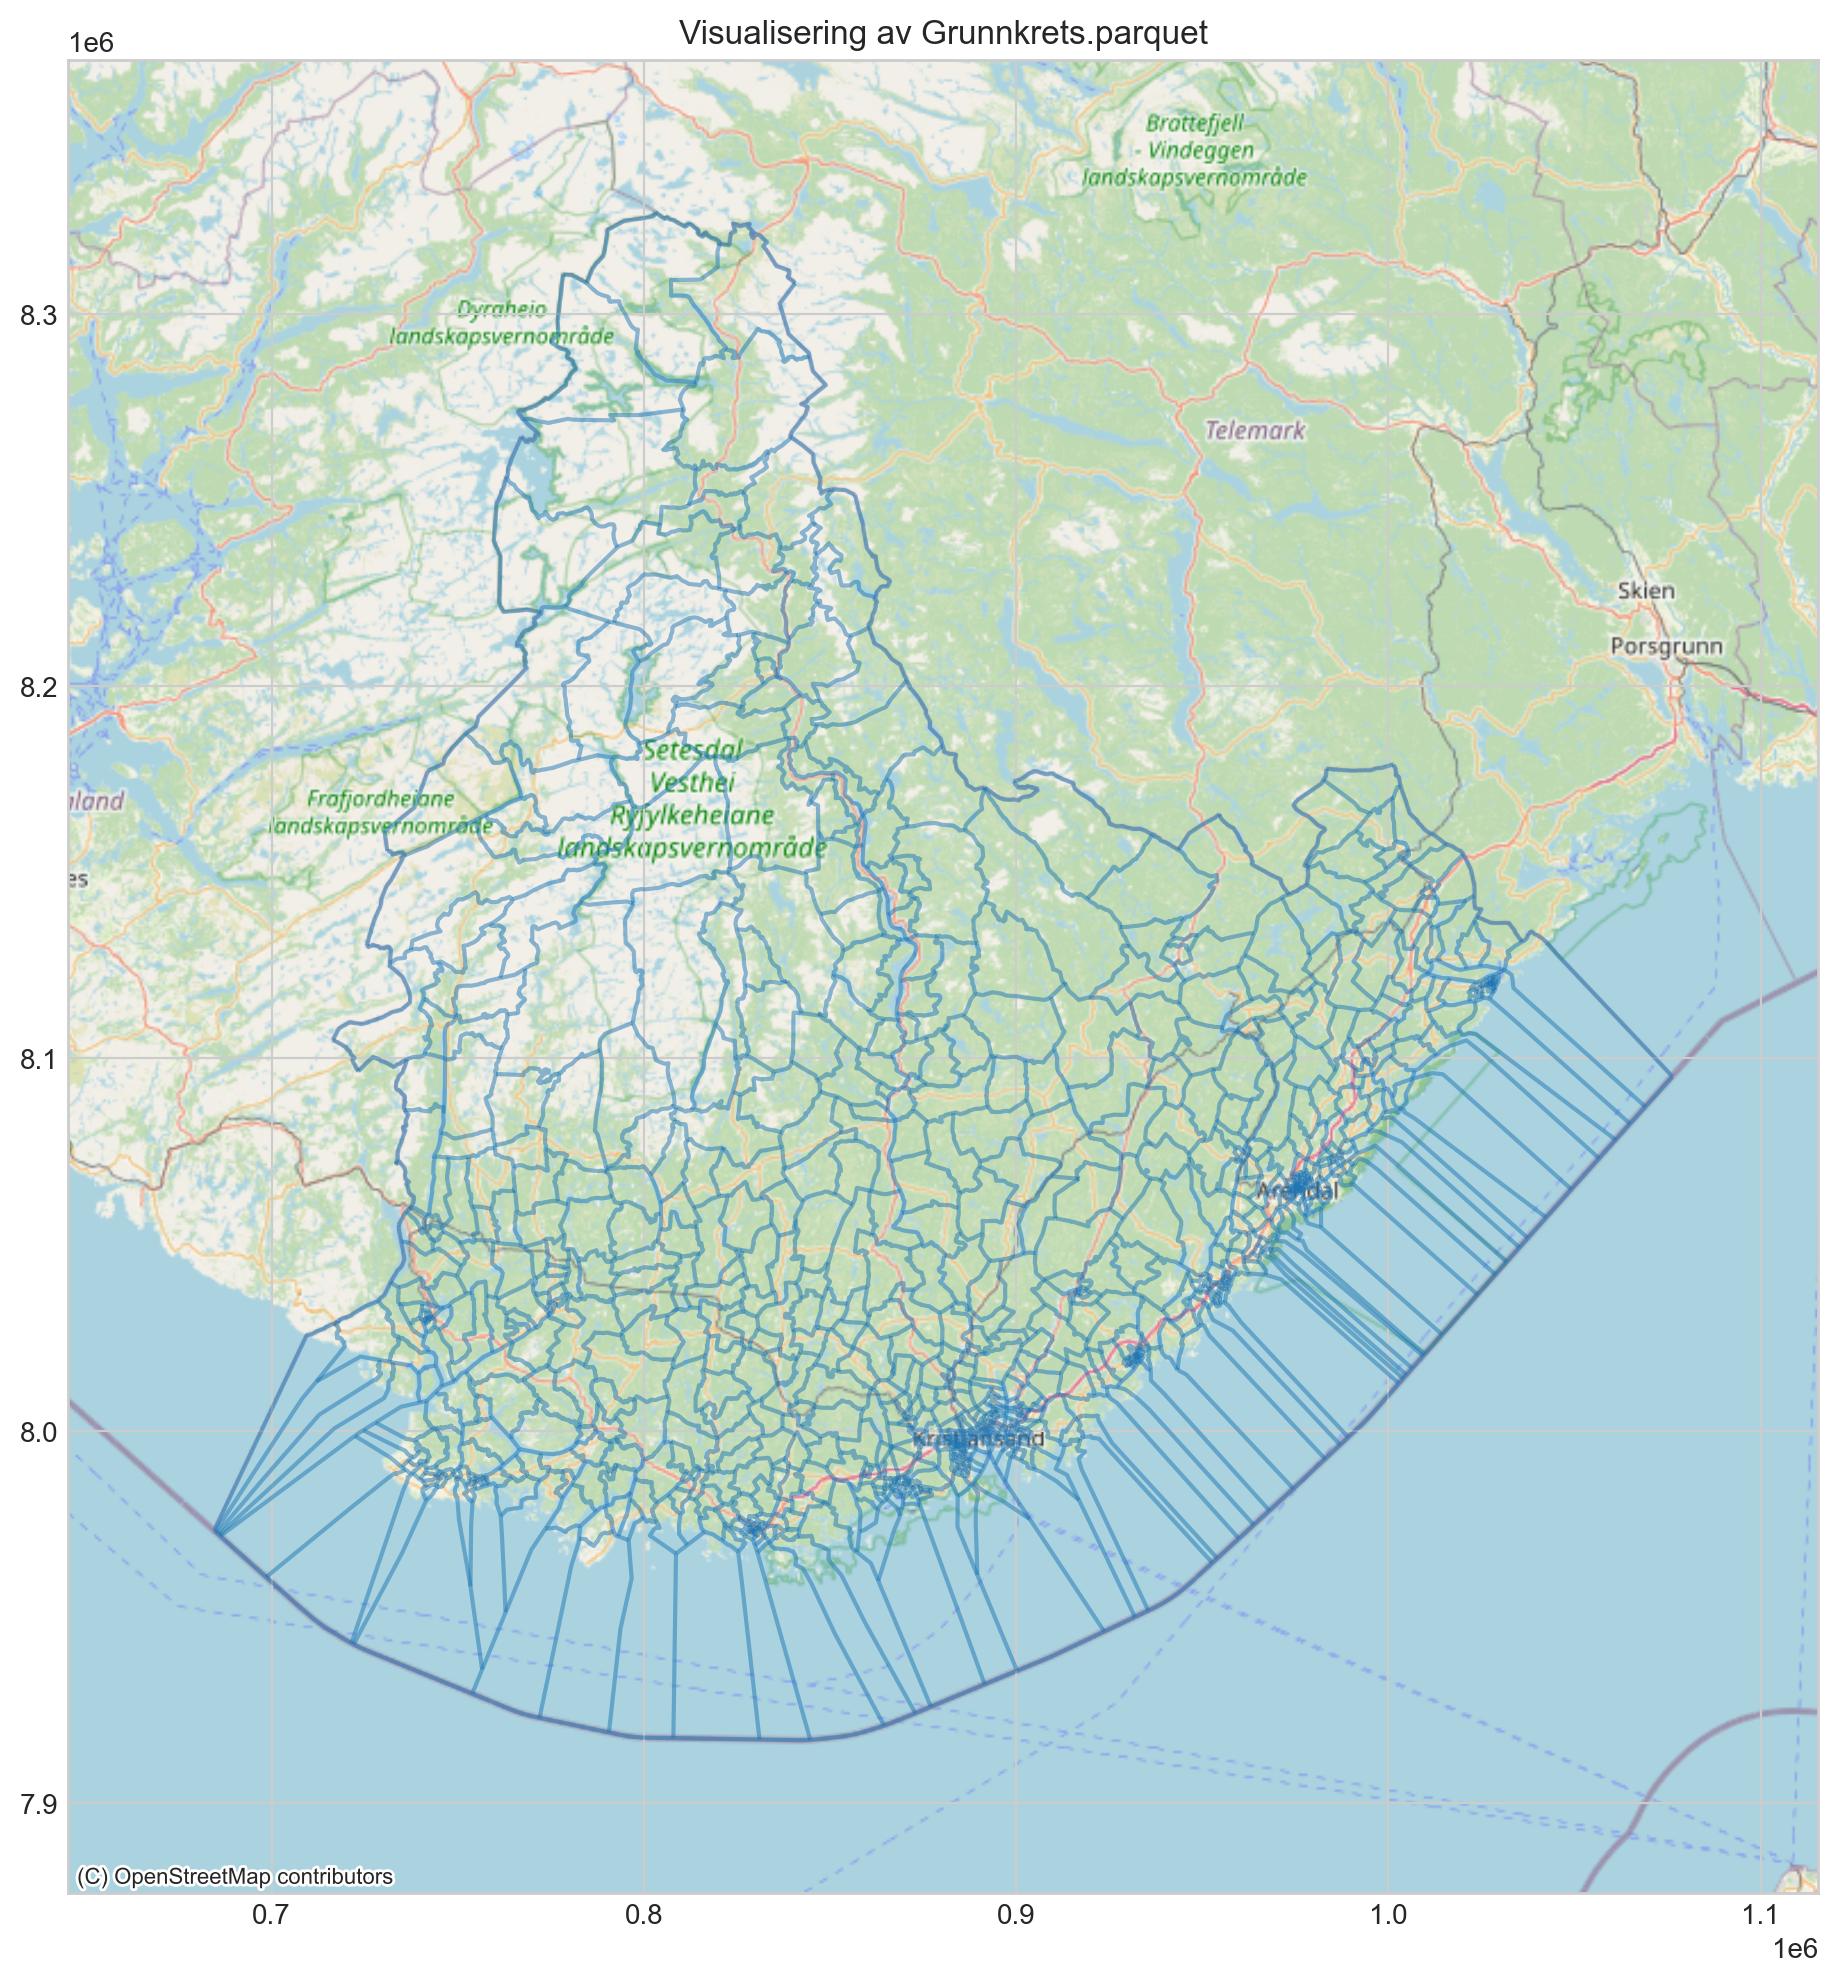


Datasettdetaljer:
Antall rader: 2613
Kolonner: gml_id, geometry


In [15]:
def visualiser_geoparquet(filsti=None):
    """
    Visualiserer en GeoParquet-fil med bakgrunnskart
    
    Args:
        filsti: Sti til GeoParquet-filen som skal visualiseres
                Hvis None, vises en liste over tilgjengelige filer å velge fra
    """
    prosessert_mappe = os.path.join("./data", "prosessert")
    
    # Håndter filvalg
    if filsti is None:
        filsti = velg_fil(prosessert_mappe)
        if filsti is None:
            return
    
    # Les og valider data
    gdf = les_geoparquet(filsti)
    if gdf is None or len(gdf) == 0:
        return
        
    # Vis informasjon om dataene
    print_geodataframe_info(gdf, filsti)
    
    # Opprett figur og visualiser
    visualiser_geodata(gdf, filsti)
    
    # Vis datadetaljer
    vis_datadetaljer(gdf)


def velg_fil(mappe):
    """Vis liste over tilgjengelige filer og la brukeren velge"""
    konverterte_filer = [f for f in os.listdir(mappe) 
                         if os.path.isfile(os.path.join(mappe, f)) 
                         and f.endswith('.parquet')]
    
    if not konverterte_filer:
        print("Ingen GeoParquet-filer funnet i prosessert-mappen.")
        return None
    
    print("Tilgjengelige GeoParquet-filer:")
    for i, fil in enumerate(konverterte_filer):
        print(f"{i+1}. {fil}")
    
    try:
        valg = int(input("\nVelg fil-nummer å visualisere (1-{}): ".format(len(konverterte_filer))))
        if valg < 1 or valg > len(konverterte_filer):
            print("Ugyldig valg")
            return None
        return os.path.join(mappe, konverterte_filer[valg-1])
    except ValueError:
        print("Ugyldig input: Vennligst skriv inn et tall.")
        return None


def les_geoparquet(filsti):
    """Les GeoParquet-fil og valider geometrier"""
    try:
        gdf = gpd.read_parquet(filsti)
    except Exception as e:
        print(f"Feil ved lesing av filen: {e}")
        return None
    
    # Sjekk om geometri-kolonnen eksisterer
    if not hasattr(gdf, 'geometry') or 'geometry' not in gdf.columns:
        print(f"Filen {os.path.basename(filsti)} har ingen geometri-kolonne.")
        print("Dataramme innhold:")
        display(gdf.head())
        return None
    
    # Fjern rader med manglende geometri
    gdf = gdf.dropna(subset=['geometry'])
    
    if len(gdf) == 0:
        print("Ingen gyldige geometrier funnet i filen.")
        return None
    
    # Valider geometrier
    try:
        invalid_geoms = gdf[~gdf.geometry.is_valid]
        if len(invalid_geoms) > 0:
            print(f"Advarsel: {len(invalid_geoms)} ugyldige geometrier funnet. Disse blir fjernet.")
            gdf = gdf[gdf.geometry.is_valid]
    except Exception as e:
        print(f"Kunne ikke validere geometrier: {e}")
    
    return gdf


def print_geodataframe_info(gdf, filsti):
    """Skriv ut informasjon om dataene"""
    print(f"Visualiserer {os.path.basename(filsti)}")
    print(f"Antall objekter: {len(gdf)}")
    
    if len(gdf) == 0:
        print("Ingen gyldige geometrier å vise.")
        return
    
    try:
        geom_type = gdf.geometry.geom_type.iloc[0]
        print(f"Geometritype: {geom_type}")
    except:
        print("Kunne ikke fastsette geometritype.")


def visualiser_geodata(gdf, filsti):
    """Visualiser geodata med bakgrunnskart"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Bestem geometritype for plotting
    try:
        geom_type = gdf.geometry.geom_type.iloc[0]
    except:
        geom_type = "unknown"
    
    # Plot med ulik stil basert på geometritype
    plot_basert_paa_geometritype(gdf, ax, geom_type)
    
    # Håndter CRS og legg til bakgrunnskart
    legg_til_bakgrunnskart(gdf, ax)
    
    ax.set_title(f"Visualisering av {os.path.basename(filsti)}")
    plt.tight_layout()
    plt.show()


def plot_basert_paa_geometritype(gdf, ax, geom_type):
    """Plot geodata basert på geometritype"""
    try:
        if geom_type in ['Point', 'MultiPoint']:
            gdf.plot(ax=ax, markersize=5, color='red', alpha=0.7)
        elif geom_type in ['LineString', 'MultiLineString']:
            gdf.plot(ax=ax, linewidth=1, color='blue', alpha=0.7)
        else:  # Polygon, MultiPolygon eller ukjent
            gdf.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.7)
    except Exception as e:
        print(f"Feil ved plotting av geometri: {e}")
        try:
            gdf.plot(ax=ax)
            print("Bruker enkel plotting som fallback.")
        except Exception as e2:
            print(f"Kunne ikke plotte geometriene: {e2}")


def legg_til_bakgrunnskart(gdf, ax):
    """Legg til bakgrunnskart og juster kartvisning"""
    # Håndter manglende CRS
    if gdf.crs is None:
        print("Merk: CRS mangler. Antar WGS84 (EPSG:4326) for visualisering.")
        gdf.set_crs(epsg=4326, inplace=True)
    
    try:
        # Konverter til web mercator for bakgrunnskart
        gdf_webmerc = gdf.to_crs(epsg=3857)
        
        # Kontroller at bounds er gyldige
        bounds = gdf_webmerc.total_bounds
        x_min, y_min, x_max, y_max = bounds
        
        # Sjekk om bounds inneholder NaN eller Inf eller er degenerert
        if (np.isnan(bounds).any() or np.isinf(bounds).any() or 
            x_min == x_max or y_min == y_max):
            raise ValueError("Ugyldig bounding box")
            
        # Beregn margin og sett kartets utstrekning
        margin_x = (x_max - x_min) * 0.1
        margin_y = (y_max - y_min) * 0.1
        ax.set_xlim(x_min - margin_x, x_max + margin_x)
        ax.set_ylim(y_min - margin_y, y_max + margin_y)
        
        # Legg til bakgrunnskart
        gdf_webmerc.plot(ax=ax, alpha=0.5)
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        
    except Exception as e:
        print(f"Feil ved håndtering av kartvisning: {e}")
        print("Viser data uten bakgrunnskart.")
        gdf.plot(ax=ax, alpha=0.5)


def vis_datadetaljer(gdf):
    """Vis detaljer om datasettet"""
    print("\nDatasettdetaljer:")
    print(f"Antall rader: {len(gdf)}")
    print(f"Kolonner: {', '.join(gdf.columns)}")
    
    # Hvis det er få rader, vis dataene
    if len(gdf) <= 5:
        print("\nDatainnhold:")
        display(gdf)


visualiser_geoparquet()